<hr style="color:green" />
<h1 style="color:green">COSC2673 Assignment 2: Image Classification for Cancerous Cells</h1>
<h2 style="color:green">File 12: Basic PyTorch Fully Connected Neural Network model - Basic 3 Layer with Early Stopping</h2>
<hr style="color:green" />

<p>
In this file, attempt to apply techniques to deal with overfitting on the Basic 01 (3 layer FC NN) model. Implement Early Stopping to try to mitigate overfitting
</p>

In [1]:
import pandas as pd
import numpy as np
import os
import cv2

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torch.utils.data
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.io import read_image


Configure this script as to whether it runs on Google Colab, or locally

In [2]:
# When on Google Colab, running full training, change both to true. Locally, advised set both to false
isGoogleColab = True
useFullData = True

In [3]:
# In local, the base directory is the current directory
baseDirectory = "./"

if isGoogleColab:
    from google.colab import drive
    
    # If this is running on Google colab, assume the notebook runs in a "COSC2673" folder, which also contains the data files 
    # in a subfolder called "image_classification_data"
    drive.mount("/content/drive")
    !ls /content/drive/'My Drive'/COSC2673/

    # Import the directory so that custom python libraries can be imported
    import sys
    sys.path.append("/content/drive/MyDrive/COSC2673/")

    # Set the base directory to the Google Drive specific folder
    baseDirectory = "/content/drive/MyDrive/COSC2673/"

Mounted at /content/drive
05a.PyTorchGetMeanAndStd.ipynb	       a2_utility.py
05c.PyTorchBaseline.ipynb	       data_basic_utility.py
06.PyTorchBasic01.ipynb		       dataframe_utility.py
07.PyTorchBasic02.ipynb		       graphing_utility.py
08.PyTorchBasic03.ipynb		       Image_classification_data
09.PyTorchBasic01_TuneLR.ipynb	       Image_classification_data.zip
10.PyTorchBasic01_CV.ipynb	       images_main.csv
11.PyTorchBasic01_overfitting.ipynb    __pycache__
13.PyTorchBasic01_earlystopping.ipynb  pytorch_utility.py
20.PyTorchCNN01.ipynb		       statistics_utility.py
21.PyTorchCNN02.ipynb


Import the custom python files that contain reusable code

In [4]:
import data_basic_utility as dbutil
import graphing_utility as graphutil
import statistics_utility as statsutil

import a2_utility as a2util
import pytorch_utility as ptutil
from pytorch_utility import CancerBinaryDataset
from pytorch_utility import CancerCellTypeDataset


# randomSeed = dbutil.get_random_seed()
randomSeed = 266305
print("Random Seed: " + str(randomSeed))

Random Seed: 266305


In [5]:
# this file should have previously been created in the root directory
dfImages = pd.read_csv(baseDirectory + "images_main.csv")

In [6]:
# Get The training Split and the Validation Split
dfImagesTrain = dfImages[dfImages["trainValTest"] == 0].reset_index()
dfImagesVal = dfImages[dfImages["trainValTest"] == 1].reset_index()
dfImagesTest = dfImages[dfImages["trainValTest"] == 2].reset_index()

print(dfImagesTrain.shape)
print(dfImagesVal.shape)
print(dfImagesTest.shape)

dfImagesTrain.head()

(7837, 5)
(1031, 5)
(1028, 5)


,index,ImageName,isCancerous,cellType,trainValTest
0,0,./Image_classification_data/patch_images\1.png,0,0,0
1,1,./Image_classification_data/patch_images\10.png,0,0,0
2,3,./Image_classification_data/patch_images\1000.png,1,2,0
3,4,./Image_classification_data/patch_images\10000...,0,1,0
4,5,./Image_classification_data/patch_images\10001...,0,1,0


Note: The definition of the Custom Datasets for both the isCancerous data and the Cell Type data are defined in the pytorch_utility.py file.

Also, rather than loading all the training images and calculating the mean and standard deviation values in here, that was run separately in file 05a.PyTorchGetMeanAndStd.ipynb

Here we can just define the values to use, which shouldn't change unless the data is reloaded and a new train/validation/test split is generated

In [7]:
train_mean, train_std = ptutil.getTrainMeanAndStdTensors()
print(train_mean)
print(train_std)

tensor([0.8035, 0.5909, 0.7640])
tensor([0.1246, 0.1947, 0.1714])


In [8]:
# Create a tranform operation that also normalizes the images according to the mean and standard deviations of the images
transform_normalize = transforms.Compose(
    [transforms.ToPILImage(),
    transforms.ToTensor(), 
    transforms.Normalize(train_mean, train_std)])


In [9]:
cancerous_training_data = None

# Create a custom Dataset for the training and validation data
if useFullData:
    cancerous_training_data = CancerBinaryDataset(isGoogleColab, dfImagesTrain, baseDirectory, transform=transform_normalize)
else:
    # For testing in a small dataset
    dfImagesTrainTest = dfImagesTrain.iloc[range(1000), :].reset_index()
    cancerous_training_data = CancerBinaryDataset(isGoogleColab, dfImagesTrainTest, baseDirectory, transform=transform_normalize, target_transform=None)

cancerous_validation_data = CancerBinaryDataset(isGoogleColab, dfImagesVal, baseDirectory, transform=transform_normalize, target_transform=None)
cancerous_test_data = CancerBinaryDataset(isGoogleColab, dfImagesTest, baseDirectory, transform=transform_normalize, target_transform=None)

# Create data loaders
cancerous_train_dataloader = DataLoader(cancerous_training_data, batch_size=32, shuffle=True, num_workers=2)
cancerous_val_dataloader = DataLoader(cancerous_validation_data, batch_size=32, shuffle=True, num_workers=2)
cancerous_test_dataloader = DataLoader(cancerous_test_data, batch_size=32, shuffle=True, num_workers=2)

# Early Stopping

Using the basic model (class), refactor the code such that the test and validation predictions are made at the end of each epoch and the loss difference between training error and validation error are calculated. Use the F1 Score as the metric

Also implement a "Patience" level, where the patience is the number of consecutive epochs that can occur with no improvement in loss before the process is stopped early.

In [10]:
# Create a class for the Neural Network
class PT_NN_IsCancerous(nn.Module):

    # In the constructor, initialize the layers to use
    def __init__(self):
        super(PT_NN_IsCancerous, self).__init__()
        
        self.sigmoid = nn.Sigmoid()

        self.fc1 = nn.Linear(27 * 27 * 3, 1458)
        self.fc2 = nn.Linear(1458, 729)
        self.fc3 = nn.Linear(729, 2)

    # Create the forward function, which is used in training
    def forward(self, x):
        # process through each layer
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))

        # return the result
        return x


Now train the Fully Connected Neural Network Model.

During training, we will use the following:
- Softmax Cross Entropy Loss as our Loss function. This is a good Loss function that basically converts scores for each class into probabilities
- The Adam Optimizer, which is a version of Gradient Descent
- Initially, just 10 epochs

Create a function to predict

In [11]:
def predictCancerousOnDataSetF1(net, setName, dataloader, printResult=True, printFullResults=False):
    correct, total = 0,  0
    predictions = []

    y_cancerous = []
    y_pred_cancerous = []

    # Looping through this dataloader essentially processes them in batches of 32 (or whatever the batchsize is configured in the data loader
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data

        # This should convert the image tensors into vectors
        inputs = inputs.view(-1, 27 * 27 * 3)

        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        # Loop through the batch, build the lists of the raw label and prediction values
        for j in range(len(labels)):
            y_cancerous.append(labels[j].item())
            y_pred_cancerous.append(predicted[j].item())

        predictions.append(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    f1Score = f1_score(y_cancerous, y_pred_cancerous)

    if printFullResults:
        print(setName + ":")        
        print('Confusion matrix: \n')
        print(confusion_matrix(y_cancerous, y_pred_cancerous))
        print("\n- Accuracy Score: " + str(accuracy_score(y_cancerous, y_pred_cancerous)))
        print("- Precision Score: " + str(precision_score(y_cancerous, y_pred_cancerous)))
        print("- Recall Score: " + str(recall_score(y_cancerous, y_pred_cancerous)))
        print("- F1 Score: " + str(f1Score))
    elif printResult:
        print("- " + setName + " F1: " + str(f1Score))        

    return f1Score, y_cancerous, y_pred_cancerous

In [12]:
# set the Learning Rate to use
learning_rate = 0.0001
maxEpochs = 10
patience = 2
disableEarlyStopping = True
criterion = nn.CrossEntropyLoss()

# Use this for L2 Regularization
# net = PT_NN_IsCancerous()
# optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0.0001)

# Use this for dropouts
net = PT_NN_IsCancerous()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

bestErrorDiff = 99999
concurrentNonImproves = 0
currentEpoch = 0

bestValF1 = -1
lstEpochs = []
lstTrainF1s = []
lstValF1s = []
for epoch in range(maxEpochs):
    print("Starting Epoch " + str(epoch) + "...")
    currentEpoch = epoch

    # Set the Neural Network into training mode
    net.train()

    # Train through this epoch
    for i, data in enumerate(cancerous_train_dataloader, 0):
        # Get the inputs
        inputs, labels = data

        # This should convert the image tensors into vectors
        inputs = inputs.view(-1, 27 * 27 * 3)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Perform Forward and Backward propagation then optimize the weights
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    # Set the Neural Network into evaluation (test) mode, so we can evaluate both training and validation error
    net.eval()        
    trainingF1, y_train_cancerous, y_train_pred_cancerous = predictCancerousOnDataSetF1(net, "Training", cancerous_train_dataloader, True, False)
    validationF1, y_val_cancerous, y_val_pred_cancerous = predictCancerousOnDataSetF1(net, "Validation", cancerous_val_dataloader, True, False)

    errorDiff = trainingF1 - validationF1
    print("- F1 Difference: " + str(errorDiff))

    lstEpochs.append(epoch)
    lstTrainF1s.append(trainingF1)
    lstValF1s.append(validationF1)

    if epoch > 0 and (validationF1 - bestValF1 > 0.01):        
        # There is at least percentage point improvement in the validation F1, count this as a 
        # good iteration, regardless of the error difference
        print("- IsGoodStep")
        concurrentNonImproves = 0
        if errorDiff > 0 and errorDiff < bestErrorDiff:  
            bestErrorDiff = errorDiff        
    elif errorDiff < bestErrorDiff:        
        # This epoch is an improvement on the last, so we will continue. the concurrent non improve counts reset for the patience
        print("- IsBetter: " + str(errorDiff) + " : " + str(bestErrorDiff))        
        concurrentNonImproves = 0
        if errorDiff > 0:
            bestErrorDiff = errorDiff
    else:
        # This epoch has the same or worse performance than the last. Check if we have reached the patience, if so, then stop early
        print("- IsNotBetter: " + str(errorDiff) + " : " + str(bestErrorDiff))        
        concurrentNonImproves += 1
        if disableEarlyStopping == False:
            if concurrentNonImproves >= patience:
                print("Early Stopping occurred at Epoch " + str(epoch))
                break

    # update the val F1 score from the previous epoch if it's the best
    if validationF1 > bestValF1:
        bestValF1 = validationF1


    

Starting Epoch 0...
- Training F1: 0.8719211822660097
- Validation F1: 0.88638195004029
- F1 Difference: -0.014460767774280292
- IsBetter: -0.014460767774280292 : 99999
Starting Epoch 1...
- Training F1: 0.885654156436338
- Validation F1: 0.8952837729816147
- F1 Difference: -0.00962961654527661
- IsBetter: -0.00962961654527661 : 99999
Starting Epoch 2...
- Training F1: 0.9090251401700127
- Validation F1: 0.8916256157635468
- F1 Difference: 0.01739952440646586
- IsBetter: 0.01739952440646586 : 99999
Starting Epoch 3...
- Training F1: 0.9084545956898139
- Validation F1: 0.8818635607321131
- F1 Difference: 0.026591034957700765
- IsNotBetter: 0.026591034957700765 : 0.01739952440646586
Starting Epoch 4...
- Training F1: 0.9260244811069718
- Validation F1: 0.896551724137931
- F1 Difference: 0.029472756969040725
- IsNotBetter: 0.029472756969040725 : 0.01739952440646586
Starting Epoch 5...
- Training F1: 0.937589158345221
- Validation F1: 0.8948220064724919
- F1 Difference: 0.04276715187272917

Look at the training and validation loss plot to track how the model improved during epochs

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

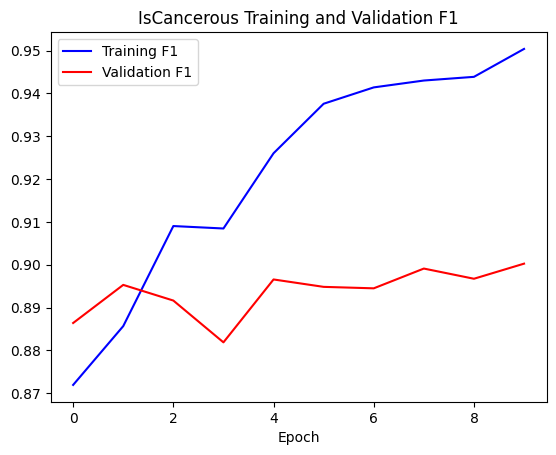

In [13]:
dfLoss = pd.DataFrame({ 'epoch': lstEpochs, 'train': lstTrainF1s, 'validation': lstValF1s })
graphutil.graphBasicTwoSeries(dfLoss, "epoch", "train", "validation", "IsCancerous Training and Validation F1", 
        "Epoch", "Training F1", "Validation F1")

Training Time in Nelson's Local Environment on the full data takes a very long time, stopped after 100 minutes. This will need to be done in Colab.

First, Predict on the training data so that we can find the training error.

In [14]:
# Use the final NN model to predict on the training data
trainingF1, y_train_cancerous, y_train_pred_cancerous = predictCancerousOnDataSetF1(net, "Training", cancerous_train_dataloader, True, True)

Training:
Confusion matrix: 

[[4896  108]
 [ 170 2663]]

- Accuracy Score: 0.9645272425673089
- Precision Score: 0.9610249007578492
- Recall Score: 0.9399929403459231
- F1 Score: 0.9503925767309065


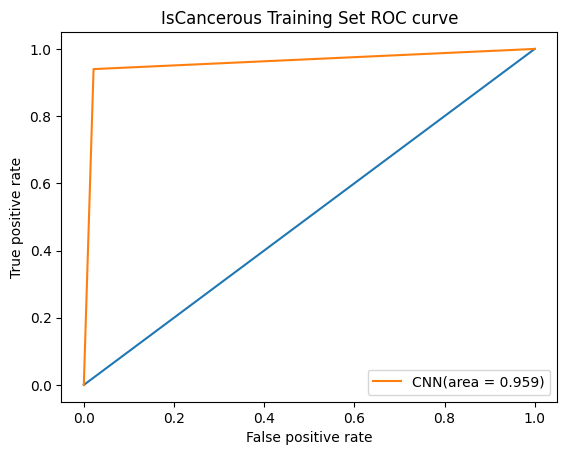

ROC (Area): 0.9592051032664868


0.9592051032664868

In [15]:
a2util.getClassificationROC("IsCancerous", "Training", y_train_cancerous, y_train_pred_cancerous)

Now Predict according to the Validation data and evaluate. While looping through here, we will need to get out the Labels from the data loader, because the order of predictions in the batches do not match the order of the original Target values in the dataset (because we turned Shuffle on)

In [16]:
testF1, y_test_cancerous, y_test_pred_cancerous = predictCancerousOnDataSetF1(net, "Test", cancerous_test_dataloader, True, True)

Test:
Confusion matrix: 

[[336  69]
 [ 61 562]]

- Accuracy Score: 0.8735408560311284
- Precision Score: 0.8906497622820919
- Recall Score: 0.9020866773675762
- F1 Score: 0.8963317384370016


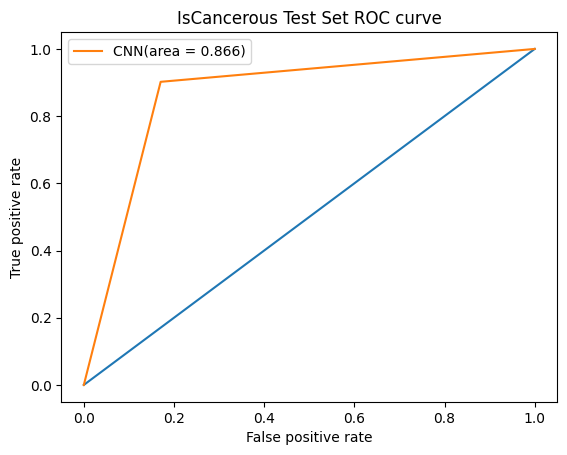

ROC (Area): 0.8658581534986028


0.8658581534986028

In [17]:
a2util.getClassificationROC("IsCancerous", "Test", y_test_cancerous, y_test_pred_cancerous, 2)

### Results

No L2 Reg or Dropout (from file 06) - On Colab, Full data
- Training Accuracy: 0.969
- Validation: 0.844

L2 with weight_decay=0.0001:
- **Training**
- Accuracy Score: 0.9960444047467143
- Precision Score: 0.998576512455516
- Recall Score: 0.9904694669961172
- F1 Score: 0.9945064681906787
- **Validation**
- Accuracy Score: 0.8516003879728419
- Precision Score: 0.8929765886287625
- Recall Score: 0.8571428571428571
- F1 Score: 0.8746928746928747

L2 with weight_decay=0.001:
- Training Accuracy: 1
- Validation: 0.56
- Very bad on Local with test data, no need to test on colab

Dropout with rate 0.5
- **Training**
- Accuracy Score: 0.9423248692101569
- Precision Score: 0.8836609732516919
- Recall Score: 0.9678785739498764
- F1 Score: 0.923854447439353
- **Validation**
- Accuracy Score: 0.8690591658583899
- Precision Score: 0.8546511627906976
- Recall Score: 0.9438202247191011
- F1 Score: 0.897025171624714

Dropout with rate 0.25
- Training Accuracy: 1
- Validation: 0.82
- not as good as 0.5 in test, no need to test on colab

Early Stopping:
- Stopped after Epoch 4 (5 Epochs)
- **Training**
- Accuracy Score: 0.9498532601760878
- Precision Score: 0.9320113314447592
- Recall Score: 0.9290504765266502
- F1 Score: 0.9305285487007248
- **Validation**
- Accuracy Score: 0.8680892337536372
- Precision Score: 0.8883572567783095
- Recall Score: 0.8940609951845907
- F1 Score: 0.8912000000000001

Now also train a model for CellType Predictions

In [18]:
celltype_training_data = None

# Create a custom Dataset for the training and validation data
if useFullData:
    celltype_training_data = CancerCellTypeDataset(isGoogleColab, dfImagesTrain, baseDirectory, transform=transform_normalize)
else:
    # For testing in a small dataset
    dfImagesTrainTest = dfImagesTrain.iloc[range(1000), :].reset_index()
    celltype_training_data = CancerCellTypeDataset(isGoogleColab, dfImagesTrainTest, baseDirectory, transform=transform_normalize, target_transform=None)

celltype_validation_data = CancerCellTypeDataset(isGoogleColab, dfImagesVal, baseDirectory, transform=transform_normalize)
celltype_test_data = CancerCellTypeDataset(isGoogleColab, dfImagesTest, baseDirectory, transform=transform_normalize)

# Create data loaders
celltype_train_dataloader = DataLoader(celltype_training_data, batch_size=32, shuffle=True, num_workers=2)
celltype_val_dataloader = DataLoader(celltype_validation_data, batch_size=32, shuffle=True, num_workers=2)
celltype_test_dataloader = DataLoader(celltype_test_data, batch_size=32, shuffle=True, num_workers=2)

Create a class for the Cell Type Neural Network model. The structure of the class will be fundamentally the same, only the model will need to output 4 classes

In [19]:
# Create a class for the Neural Network
class PT_NN_CellType(nn.Module):

    # In the constructor, initialize the layers to use
    def __init__(self):
        super(PT_NN_CellType, self).__init__()
        self.fc1 = nn.Linear(27 * 27 * 3, 1458)
        self.fc2 = nn.Linear(1458, 729)
        self.fc3 = nn.Linear(729, 4)

    # Create the forward function, which is used in training
    def forward(self, x):
        # process through each layer
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        # return the result
        return x

Now train the Fully Connected Neural Network Model. Use the same configuration (objective function, optimizer etc) as the Binary Classifier

In [20]:
def predictCellTypeOnDataSetAccuracy(net, setName, dataloader, printResult=True, printFullResults=False):
    correct, total = 0,  0
    predictions = []

    y_celltype = []
    y_pred_celltype = []
    y_pred_celltype_scores = []

    # Looping through this dataloader essentially processes them in batches of 32 (or whatever the batchsize is configured in the data loader
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data

        # This should convert the image tensors into vectors
        inputs = inputs.view(-1, 27 * 27 * 3)

        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        # Loop through the batch, build the lists of the raw label and prediction values
        for j in range(len(labels)):
            y_celltype.append(labels[j].item())
            y_pred_celltype.append(predicted[j].item())
            y_pred_celltype_scores.append(outputs.data[j].tolist())

        predictions.append(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = accuracy_score(y_celltype, y_pred_celltype)
    f1Score = f1_score(y_celltype, y_pred_celltype, average="micro")

    if printFullResults:
        print(setName + ":")        
        print('Confusion matrix: \n')
        print(confusion_matrix(y_celltype, y_pred_celltype))
        print("\n- Accuracy Score: " + str(accuracy))
        print("- Precision Score: " + str(precision_score(y_celltype, y_pred_celltype, average="micro")))
        print("- Recall Score: " + str(recall_score(y_celltype, y_pred_celltype, average="micro")))
        print("- F1 Score: " + str(f1Score))
    elif printResult:
        print("- " + setName + " F1: " + str(f1Score))

    return accuracy, y_celltype, y_pred_celltype, y_pred_celltype_scores

In [21]:
# set the Learning Rate to use
learning_rate = 0.0001
maxEpochs = 10
patience = 2
disableEarlyStopping = True
criterion = nn.CrossEntropyLoss()

# Use this for L2 Regularization
# net = PT_NN_IsCancerous()
# optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0.0001)

# Use this for dropouts
net = PT_NN_CellType()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

bestErrorDiff = 99999
concurrentNonImproves = 0
currentEpoch = 0

bestValAcc = -1
lstEpochs = []
lstTrainAccs = []
lstValAccs = []
for epoch in range(maxEpochs):
    print("Starting Epoch " + str(epoch) + "...")
    currentEpoch = epoch

    # Set the Neural Network into training mode
    net.train()

    # Train through this epoch
    for i, data in enumerate(celltype_train_dataloader, 0):
        # Get the inputs
        inputs, labels = data

        # This should convert the image tensors into vectors
        inputs = inputs.view(-1, 27 * 27 * 3)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Perform Forward and Backward propagation then optimize the weights
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    # Set the Neural Network into evaluation (test) mode, so we can evaluate both training and validation error
    net.eval()        
    trainingAccuracy, y_train_celltype, y_train_pred_celltype, y_train_pred_celltype_scores = predictCellTypeOnDataSetAccuracy(
        net, "Training", celltype_train_dataloader, True, False)
    validationAccuracy, y_val_celltype, y_val_pred_celltype, y_val_pred_celltype_scores  = predictCellTypeOnDataSetAccuracy(
        net, "Validation", celltype_val_dataloader, True, False)

    errorDiff = trainingAccuracy - validationAccuracy
    print("- Accuracy Difference: " + str(errorDiff))

    lstEpochs.append(epoch)
    lstTrainAccs.append(trainingAccuracy)
    lstValAccs.append(validationAccuracy)

    if epoch > 0 and (validationF1 - bestValF1 > 0.01):        
        # There is at least percentage point improvement in the validation F1, count this as a 
        # good iteration, regardless of the error difference
        print("- IsGoodStep")
        concurrentNonImproves = 0
        if errorDiff > 0 and errorDiff < bestErrorDiff:  
            bestErrorDiff = errorDiff        
    elif errorDiff < bestErrorDiff:        
        # This epoch is an improvement on the last, so we will continue. the concurrent non improve counts reset for the patience
        print("- IsBetter: " + str(errorDiff) + " : " + str(bestErrorDiff))        
        concurrentNonImproves = 0
        if errorDiff > 0:
            bestErrorDiff = errorDiff
    else:
        # This epoch has the same or worse performance than the last. Check if we have reached the patience, if so, then stop early
        print("- IsNotBetter: " + str(errorDiff) + " : " + str(bestErrorDiff))        
        concurrentNonImproves += 1
        if disableEarlyStopping == False:
            if concurrentNonImproves >= patience:
                print("Early Stopping occurred at Epoch " + str(epoch))
                break

    # update the val F1 score from the previous epoch if it's the best
    if validationAccuracy > bestValAcc:
        bestValAcc = validationAccuracy


Starting Epoch 0...
- Training F1: 0.7476075028709965
- Validation F1: 0.7516973811833172
- Accuracy Difference: -0.004089878312320661
- IsBetter: -0.004089878312320661 : 99999
Starting Epoch 1...
- Training F1: 0.8126834247798903
- Validation F1: 0.7807953443258971
- Accuracy Difference: 0.03188808045399316
- IsBetter: 0.03188808045399316 : 99999
Starting Epoch 2...
- Training F1: 0.8759729488324614
- Validation F1: 0.7788554801163918
- Accuracy Difference: 0.09711746871606952
- IsNotBetter: 0.09711746871606952 : 0.03188808045399316
Starting Epoch 3...
- Training F1: 0.9122113053464336
- Validation F1: 0.7565470417070804
- Accuracy Difference: 0.15566426363935304
- IsNotBetter: 0.15566426363935304 : 0.03188808045399316
Starting Epoch 4...
- Training F1: 0.9377312747224703
- Validation F1: 0.7361784675072744
- Accuracy Difference: 0.20155280721519586
- IsNotBetter: 0.20155280721519586 : 0.03188808045399316
Starting Epoch 5...
- Training F1: 0.970141635830037
- Validation F1: 0.76042677

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

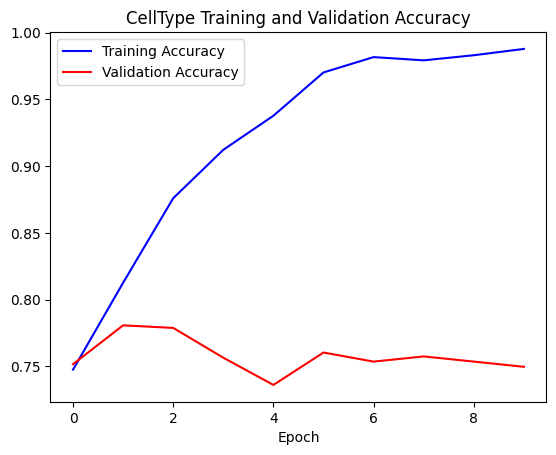

In [22]:
dfLoss = pd.DataFrame({ 'epoch': lstEpochs, 'train': lstTrainAccs, 'validation': lstValAccs })
graphutil.graphBasicTwoSeries(dfLoss, "epoch", "train", "validation", "CellType Training and Validation Accuracy", 
        "Epoch", "Training Accuracy", "Validation Accuracy")

Predict on the Training Set to get the Training Accuracy and Error

In [23]:
trainingAcc, y_train_celltype, y_train_pred_celltype, y_train_pred_celltype_scores = predictCellTypeOnDataSetAccuracy(
    net, "Training", celltype_train_dataloader, True, True)

Training:
Confusion matrix: 

[[1592    0    1    0]
 [  22 2143    6    2]
 [   0    2 2831    0]
 [  40   15    8 1175]]

- Accuracy Score: 0.9877504146995023
- Precision Score: 0.9877504146995023
- Recall Score: 0.9877504146995023
- F1 Score: 0.9877504146995023


In [24]:
for i in range(5):
    print(y_train_pred_celltype_scores[i])

[-3.7508721351623535, -8.849267959594727, 14.905204772949219, -8.117009162902832]
[-1.205639123916626, -2.1143176555633545, -1.866675853729248, 2.7993433475494385]
[5.154506683349609, -2.8502445220947266, -1.941800832748413, -2.304949998855591]
[-8.104830741882324, -2.2382426261901855, 11.385347366333008, -6.185314178466797]
[6.098112106323242, -3.3061435222625732, -3.8806819915771484, -0.8067089319229126]


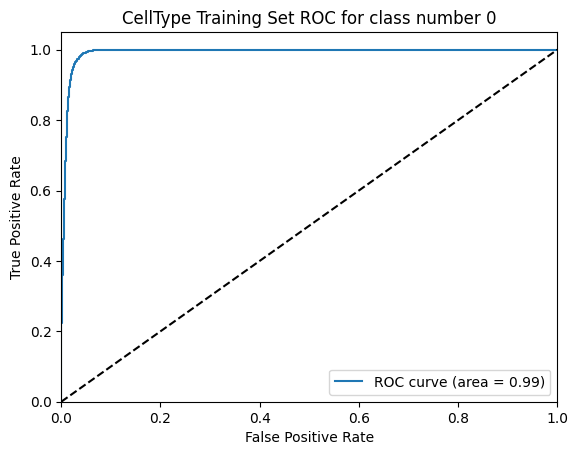

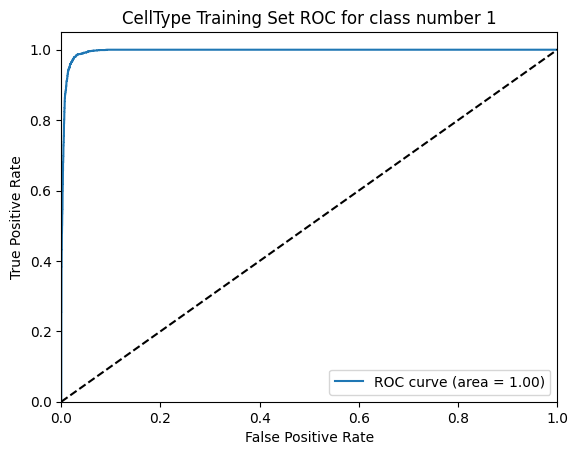

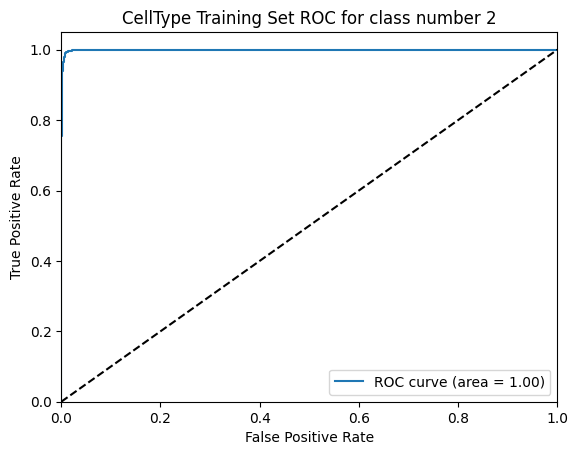

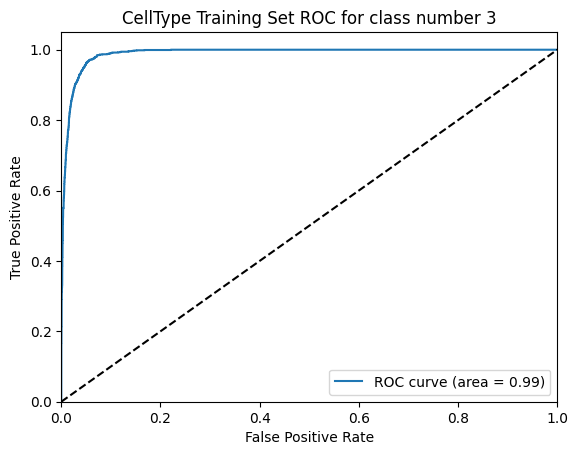

Mean ROC (Area): 0.9942493653424558


0.9942493653424558

In [25]:
a2util.getClassificationROC("CellType", "Training", y_train_celltype, y_train_pred_celltype, 4, y_train_pred_celltype_scores)

Predict on the Validation data and evaluate the results

In [26]:
testAccuracy, y_test_celltype, y_test_pred_celltype, y_test_pred_celltype_scores  = predictCellTypeOnDataSetAccuracy(
        net, "Test", celltype_test_dataloader, True, True)


Test:
Confusion matrix: 

[[ 92  15  28   5]
 [ 37 107  27  14]
 [ 22  28 568   5]
 [ 14  25  31  10]]

- Accuracy Score: 0.7558365758754864
- Precision Score: 0.7558365758754864
- Recall Score: 0.7558365758754864
- F1 Score: 0.7558365758754864


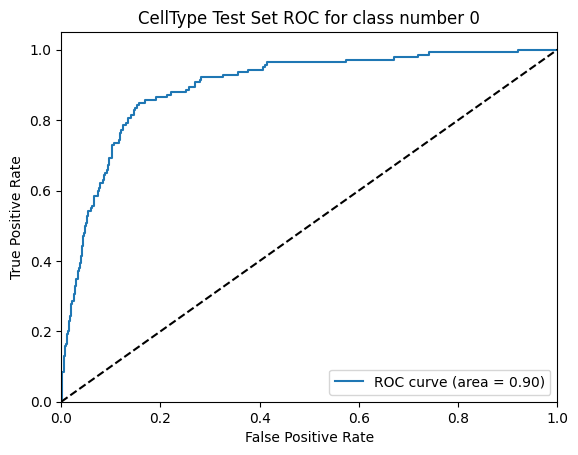

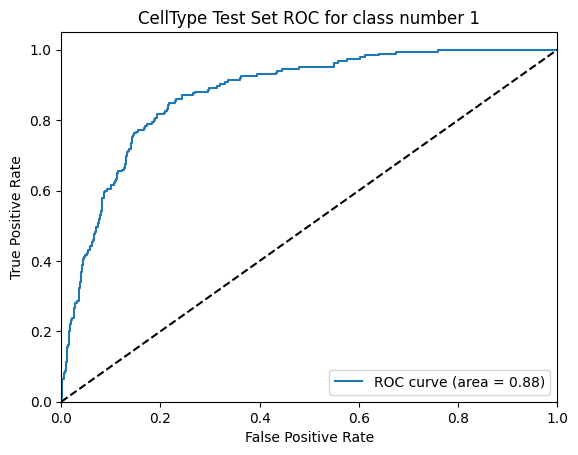

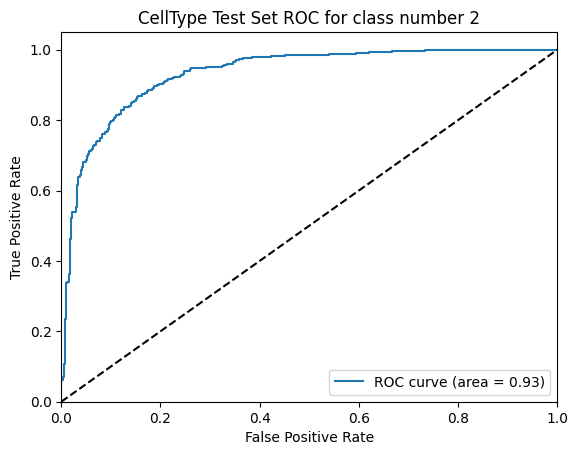

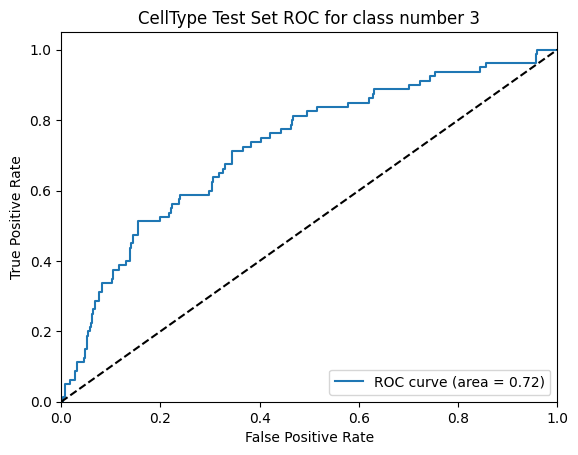

Mean ROC (Area): 0.8573832183533212


0.8573832183533212

In [27]:
a2util.getClassificationROC("CellType", "Test", y_test_celltype, y_test_pred_celltype, 4, y_test_pred_celltype_scores)

### Results

No L2 Reg or Dropout (from file 06) - On Colab, Full data
- Training Accuracy: 0.995
- Validation: 0.763

L2 with weight_decay=0.0001:
- **Training**
- Accuracy Score: 0.988898813321424
- Precision Score: 0.988898813321424
- Recall Score: 0.988898813321424
- F1 Score: 0.988898813321424
- **Validation**
- Accuracy Score: 0.7371483996120272
- Precision Score: 0.7371483996120272
- Recall Score: 0.7371483996120272
- F1 Score: 0.7371483996120272

L2 with weight_decay=0.001:
- Training Accuracy: 1
- Validation: 0.56
- Very bad

Dropout with rate 0.5
- **Training**
- Accuracy Score: 0.8442005869592957
- Precision Score: 0.8442005869592957
- Recall Score: 0.8442005869592957
- F1 Score: 0.8442005869592957
- **Validation**
- Accuracy Score: 0.7778855480116392
- Precision Score: 0.7778855480116392
- Recall Score: 0.7778855480116392
- F1 Score: 0.7778855480116392

Dropout with rate 0.25
- Training Accuracy: 1
- Validation: 0.82

Early Stopping:
- Stopped after Epoch 4 (5 Epochs)
- **Training**
- Accuracy Score: 0.9155289013653184
- Precision Score: 0.9155289013653184
- Recall Score: 0.9155289013653184
- F1 Score: 0.9155289013653184
- **Validation**
- Accuracy Score: 0.7487875848690592
- Precision Score: 0.7487875848690592
- Recall Score: 0.7487875848690592
- F1 Score: 0.7487875848690592

<h1>Analysis of Performance and Accuracy</h1>

<strong>Binary Classification - IsCancerous</strong>
<p>
In this model we see that the model has a very low training error and a high accuracy value, in this experiment achieving a 100% accuracy. This indicates that the model has <strong>low bias</strong>. However, when predicting on the validation dataset, the validation error rises. It can be seen that the Accuracy for the validation predictions is 84%, and the are under the ROC Curve is significantly less, with a value of 0.82. This is an indication of <strong>high variance</strong>, and in combination with low bias, indicates a possible problem of <strong>overfitting</strong>
</p>

<strong>Multi-class Classification - Cell Type</strong>
<p>
Similarly, the Cell Type model has a very low training error and a high accuracy value of 99.17%, indicating that the model has <strong>low bias</strong>. However, the Cell Type model has a considerably worse accuracy of only 72.94% when predicting on the validation dataset. A ROC curve is generated for each class, and it can be seen that the model performs better at predicting some classes compared to others. The average the under the ROC Curve score, with a value of 0.84. This indication of <strong>high variance</strong>, and in combination with low bias, indicates a possible problem of <strong>overfitting</strong>.
</p>


<strong>Next Steps</strong>
<p>
Before fully understanding this model configuration and exploring possible different models, first attempt to improve the performance of this model and fix any issues it might have
</p>
<p>
Common methods to deal with overfitting is to apply some form of regularization, such as Early Stopping or Dropout
</p>
<p>
Additionally, we can attempt to improve the accuracy in general with some methods such as adding additional layers and/or neurons per layer. However, this isn't too useful at this stage since the training accuracy is very high, indicating the complexity of the model at this stage is sufficient to capture enough complexity for good prediction.
</p>

